<a href="https://colab.research.google.com/github/PECO-chan/Keras-book-practice/blob/master/copy_chap8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import numpy as np

Using TensorFlow backend.


In [0]:
path = keras.utils.get_file(
  "nietzsche.txt",
  origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)
text = open(path).read().lower()
print("Corpus length:", len(text))

606208/600901 [==============================] - 0s 0us/step
Corpus length: 600893


In [0]:
text

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to truth, have been unskilled and unseemly methods for\nwinning a woman? certainly she has never allowed herself to be won; and\nat present every kind of dogma stands with sad and discouraged mien--if,\nindeed, it stands at all! for there are scoffers who maintain that it\nhas fallen, that all dogma lies on the ground--nay more, that it is at\nits last gasp. but to speak seriously, there are good grounds for hoping\nthat all dogmatizing in philosophy, whatever solemn, whatever conclusive\nand decided airs it has assumed, may have been only a noble puerilism\nand tyronism; and probably the time is at hand when it will be once\nand again understood what has actually sufficed for the basis of such\

In [0]:
maxlen = 60
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
  sentences.append(text[i: i+maxlen])
  next_chars.append(text[i+maxlen]) 

In [0]:
#for i in range(0, 100, 5):
#  print(i)

In [0]:
print(len(sentences))

200278


In [0]:
#set(text)
#ただの使われてる文字の集合

In [0]:
chars = sorted(list(set(text)))
len(chars)

57

In [0]:
char_indices = dict((char, chars.index(char)) for char in chars)

In [0]:
#[chars.index(char) for char in chars]

In [0]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

  #60文字分のone-hotベクトルが説明変数で、次の1文字のone-hotが目的変数

In [0]:
from keras import layers
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(lr=0.01))

In [0]:
def sample(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [0]:
'''
for i in range(10):
  tmp = np.random.multinomial(1, [0.1, 0.2, 0.3, 0.4], 1)
  print(tmp)
  print(np.argmax(tmp))
'''

'\nfor i in range(10):\n  tmp = np.random.multinomial(1, [0.1, 0.2, 0.3, 0.4], 1)\n  print(tmp)\n  print(np.argmax(tmp))\n'

In [0]:
import random
import sys

In [0]:
for epoch in range(1, 60):
  print("epoch", epoch)
  model.fit(x, y, batch_size=128, epochs = 1)
  start_index = random.randint(0, len(text) - maxlen - 1)
  generated_text = text[start_index: start_index+maxlen]
  print('--- Generating with seed: "' + generated_text + '"')
  
  for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)
    
    for i in range(400):
      sampled = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1.
        
      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = chars[next_index]
      generated_text += next_char
      generated_text = generated_text[1:]
      
      sys.stdout.write(next_char)
      sys.stdout.flush()

**DeepDream**

In [0]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 3s 0us/step


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [0]:
model.layers[30].name

'conv2d_11'

In [0]:
model.layers[30].output

<tf.Tensor 'conv2d_11/convolution:0' shape=(?, ?, ?, 96) dtype=float32>

In [0]:
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), "float32"))
  loss = loss + coeff*K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [0]:
a = K.prod(K.variable([[1,2,3,4,5],
                       [3,4,5,6,7]]),
           axis = None,
           keepdims=True)
K.eval(a)

array([[302400.]], dtype=float32)

In [0]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads = grads / K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

In [0]:
a = K.variable(5.)
K.eval(K.gradients(2*K.square(a), a)[0])

20.0

In [0]:
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('...Loss value at', i, ":", loss_value)
    x = x + step*grad_values
  return x

In [0]:
import scipy
from keras.preprocessing import image

In [0]:
def resize_img(img, size):
  img = np.copy(img)
  factors = (1,
             float(size[0]) / img.shape[1],
             float(size[1]) / img.shape[2],
             1)
  return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
  pil_img = deprocess_image(np.copy(img))
  scipy.misc.imsave(fname, pil_img)
  
def preprocess_image(image_path):
  img = image.load_img(image_path)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.
  x += 0.5
  x *= 255.
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
import numpy as np 

In [0]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

In [0]:
max_loss = 10.

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
!ls

sample_data  yui.jpg


In [0]:
base_image_path = "./yui.jpg"

In [0]:
img = preprocess_image(base_image_path)

In [0]:
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

In [0]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [0]:
for shape in successive_shapes:
  print("Processing image shape", shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,
                        iterations=iterations,
                        step=step,
                        max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img = img + lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname="dream_at_scale_" + str(shape) + ".png")

save_img(img, fname="final_dream.png")

Processing image shape (183, 326)
...Loss value at 0 : 1.5275542
...Loss value at 1 : 1.7639034
...Loss value at 2 : 2.2319577
...Loss value at 3 : 2.7443295
...Loss value at 4 : 3.271743
...Loss value at 5 : 3.7503219
...Loss value at 6 : 4.1804433
...Loss value at 7 : 4.6537714
...Loss value at 8 : 5.0871487
...Loss value at 9 : 5.504421
...Loss value at 10 : 5.916966
...Loss value at 11 : 6.30476
...Loss value at 12 : 6.692923
...Loss value at 13 : 6.991707
...Loss value at 14 : 7.409781
...Loss value at 15 : 7.786255
...Loss value at 16 : 8.14335
...Loss value at 17 : 8.477786
...Loss value at 18 : 8.801217
...Loss value at 19 : 9.184676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (257, 457)
...Loss value at 0 : 2.7970722
...Loss value at 1 : 4.0098677
...Loss value at 2 : 4.9979906
...Loss value at 3 : 5.8561687
...Loss value at 4 : 6.637766
...Loss value at 5 : 7.37537
...Loss value at 6 : 8.057569
...Loss value at 7 : 8.708951
...Loss value at 8 : 9.252018
...Loss value at 9 : 9.846084
Processing image shape (360, 640)
...Loss value at 0 : 3.0765607
...Loss value at 1 : 4.2648497
...Loss value at 2 : 5.277518
...Loss value at 3 : 6.1635933
...Loss value at 4 : 7.0077753
...Loss value at 5 : 7.7764387
...Loss value at 6 : 8.512261
...Loss value at 7 : 9.195148
...Loss value at 8 : 9.843096


スタイル変換はつまらなさそうだから、変分オートエンコーダとGANやる

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [0]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2

In [3]:
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = layers.Conv2D(64, 3, padding="same", activation="relu", strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [6]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)
  
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x


In [0]:
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [12]:
(x_train, _), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
x_train = x_train.astype("float32") / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype("float32") / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [14]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data = (x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 821us/step - loss: 0.2120 - val_loss: 0.1970
Epoch 2/10
60000/60000 [==============================] - 44s 727us/step - loss: 0.1924 - val_loss: 0.1886
Epoch 3/10
60000/60000 [==============================] - 43s 719us/step - loss: 0.1877 - val_loss: 0.1859
Epoch 4/10
60000/60000 [==============================] - 43s 719us/step - loss: 0.1851 - val_loss: 0.1840
Epoch 5/10
60000/60000 [==============================] - 43s 721us/step - loss: 0.1834 - val_loss: 0.1836
Epoch 6/10
60000/60000 [==============================] - 43s 718us/step - loss: 0.1823 - val_loss: 0.1841
Epoch 7/10
60000/60000 [==============================] - 43s 720us/step - loss: 0.1814 - val_loss: 0.1815
Epoch 8/10
60000/60000 [==============================] - 42s 708us/step - loss: 0.1806 - val_loss: 0.1805
Epoch 9/10
60000/60000 [======================

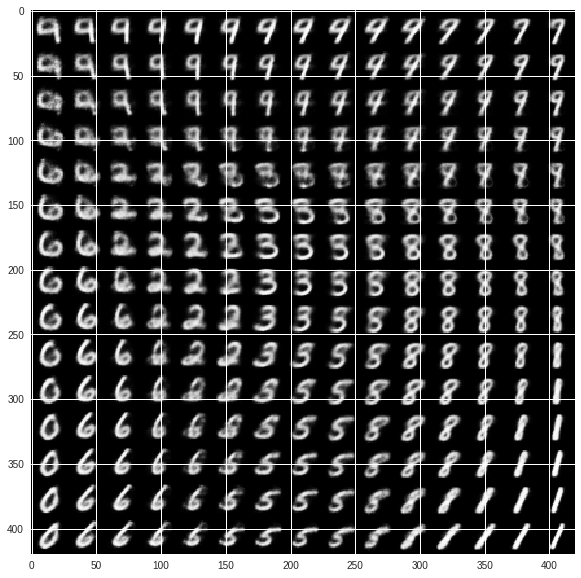

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i*digit_size:(i+1)*digit_size,
           j*digit_size:(j+1)*digit_size] = digit
    
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap="Greys_r")
plt.show()

GAN